In [427]:
import pandas as pd
import matplotlib.pyplot as plt
import datetime as DT
import yfinance as yf
import numpy as np
import scipy.stats as stats
from sklearn.linear_model import LinearRegression
import pandas_market_calendars as mcal
import datetime
#from mpl_toolkits.mplot3d import axes3d
import scipy as sp
import scipy.interpolate
from scipy.stats import norm
import math

import numpy as np
import pandas as pd
from scipy.stats import t, norm
from pycopula.copula import GaussianCopula
from scipy.optimize import minimize

In [428]:
def load_data(file_path):
    data = pd.read_csv(file_path)
    data.index = pd.to_datetime(data['Date'], format='%m/%d/%Y')
    data['Price'] = data['Price'].str.replace(',', '').astype(float)
    data['Log Return'] = np.log(data['Price'] / data['Price'].shift(1))
    data = data.dropna(subset=['Log Return'])
    return data

file_path = "../Data CSV/SMI Historical Data.csv"
smi = load_data(file_path)

file_path = "../Data CSV/S&P 500 Historical Data.csv"
sp500 = load_data(file_path)

file_path = "../Data CSV/Euro Stoxx 50 Historical Data.csv"
stoxx50 = load_data(file_path)

# Load and prepare the data
r = pd.read_excel("../Data CSV/US Interest Rates.xlsx")
r.columns = r.columns.str.strip()
r = r.dropna(subset=["United States Treasury 10-YR Rates"])
r["United States Treasury 10-YR Rates"] = pd.to_numeric(
    r["United States Treasury 10-YR Rates"], errors="coerce"
)
r['Dates'] = pd.to_datetime(r['Dates'])
r = r.sort_values(by='Dates')
r.set_index('Dates', inplace=True)
r["United States Treasury 10-YR Rates"] *= 0.01

In [429]:
common_dates = list(set(stoxx50.index).intersection(set(smi.index).intersection(set(sp500.index).intersection(set(r.index)))))
## losing data on dates, simulation also assuming common dates, losing about 14% data
print("Data Loss:", (3*len(common_dates))/(len(stoxx50)+len(smi)+len(sp500)))

def load_data(file_path):
    data = pd.read_csv(file_path)
    data.index = pd.to_datetime(data['Date'], format='%m/%d/%Y')
    data = data[data.index.isin(common_dates)]
    data['Price'] = data['Price'].str.replace(',', '').astype(float)
    data['Log Return'] = np.log(data['Price'] / data['Price'].shift(1))
    data.drop(columns=["Change %"], errors = "Ignore", inplace = True)
    data = data.dropna(subset=['Log Return'])
    return data

file_path = "../Data CSV/SMI Historical Data.csv"
smi = load_data(file_path)

file_path = "../Data CSV/S&P 500 Historical Data.csv"
sp500 = load_data(file_path)

file_path = "../Data CSV/Euro Stoxx 50 Historical Data.csv"
stoxx50 = load_data(file_path)

returns = pd.DataFrame({
    'SMI': smi['Log Return'],
    'STOXX50': stoxx50['Log Return'],
    'SP500': sp500['Log Return']
}).dropna()

chf = pd.read_csv("../Data CSV/USD_CHF Historical Data.csv")
chf.index = pd.DatetimeIndex(chf["Date"])
eur = pd.read_csv("../Data CSV/USD_EUR Historical Data.csv")
eur.index = pd.DatetimeIndex(eur["Date"])

Data Loss: 0.3937621832358674


## Simulation using Student T

In [430]:
# params_smi = t.fit(returns['SMI'])
# params_stoxx50 = t.fit(returns['STOXX50'])
# params_sp500 = t.fit(returns['SP500'])

# corr_matrix = returns.corr()
# chol_matrix = np.linalg.cholesky(corr_matrix)

In [431]:
# n_simulations = 1
# n_timesteps = 30

# z = np.random.normal(size=(n_timesteps, n_simulations, 3))
# correlated_z = np.matmul(z, chol_matrix.T)
# u = norm.cdf(correlated_z)

# sim_smi = t.ppf(u[:, :, 0], *params_smi)
# sim_stoxx50 = t.ppf(u[:, :, 1], *params_stoxx50)
# sim_sp500 = t.ppf(u[:, :, 2], *params_sp500)

# initial_prices = {
#     'SMI': smi['Price'].iloc[-1],
#     'STOXX50': stoxx50['Price'].iloc[-1],
#     'SP500': sp500['Price'].iloc[-1]
# }

# price_paths_smi = initial_prices['SMI'] * np.exp(np.cumsum(sim_smi, axis=0))
# price_paths_stoxx50 = initial_prices['STOXX50'] * np.exp(np.cumsum(sim_stoxx50, axis=0))
# price_paths_sp500 = initial_prices['SP500'] * np.exp(np.cumsum(sim_sp500, axis=0))

# price_paths = {
#     'SMI': price_paths_smi,
#     'STOXX50': price_paths_stoxx50,
#     'SP500': price_paths_sp500
# }

In [432]:
# corr_matrix

## Simulation using GBM with the CIR model

Using an MLE to estimate paramters for the CIR model

In [433]:
# Define the negative log-likelihood function. Here we fix theta to be 3.84%, according to US Long-Term Monthly Rate Analysis
def negative_log_likelihood_fixed_theta(params, r_df, theta=0.0384):
    kappa, sigma_r = params
    if kappa <= 0 or sigma_r <= 0:
        return np.inf
    log_likelihood = 0
    rates = r_df["United States Treasury 10-YR Rates"].values
    dates = r_df.index
    for t in range(len(rates) - 1):
        r_t = rates[t]
        r_t1 = rates[t + 1]
        dr = r_t1 - r_t
        dt_days = (dates[t + 1] - dates[t]).days
        dt = dt_days / 252
        if dt <= 0:
            continue
        mean_increment = kappa * (theta - r_t) * dt
        variance_increment = sigma_r**2 * r_t * dt
        if variance_increment <= 0:
            return np.inf
        likelihood_t = -0.5 * np.log(2 * np.pi * variance_increment) - 0.5 * (
            (dr - mean_increment) ** 2 / variance_increment
        )
        log_likelihood += likelihood_t
    return -log_likelihood

# Initial guesses and bounds
rates = r["United States Treasury 10-YR Rates"].values
# Initial guesses and bounds for kappa and sigma_r
initial_vals = [0.1, np.std(rates)]
bounds = ((1e-5, None), (1e-5, None))

# Optimization with fixed theta
result = minimize(
    negative_log_likelihood_fixed_theta, initial_vals, args=(r,), bounds=bounds, method="L-BFGS-B"
)

kappa, sigma_r = result.x
theta = 0.0384  # Fixed value
print("Fitted Parameters with Theta Fixed at 0.0384:")
print("kappa:", kappa)
print("sigma_r:", sigma_r)
print("theta:", theta)



Fitted Parameters with Theta Fixed at 0.0384:
kappa: 0.1654225087717949
sigma_r: 0.06255376695667016
theta: 0.0384


In [434]:
print(r)

            United States Treasury 10-YR Rates
Dates                                         
2019-11-12                              0.0192
2019-11-13                              0.0188
2019-11-14                              0.0182
2019-11-15                              0.0184
2019-11-18                              0.0181
...                                        ...
2024-11-04                              0.0431
2024-11-05                              0.0426
2024-11-06                              0.0442
2024-11-07                              0.0431
2024-11-08                              0.0430

[1251 rows x 1 columns]


In [435]:
# start_date = '2024-01-01'
# final_date= '2024-09-16'
# n_simulations = 100000
# n_timesteps = len(pd.bdate_range(start=start_date,end=final_date))
# r.index = pd.to_datetime(r.index)

# dt=1/252
# mu = {}
# sigma = {}
# for index in ['SMI', 'STOXX50', 'SP500']:
#     mean_return = returns[index].mean()
#     # Here we use ddof=1 to obtain an unbiased estimator of the variance by dividing by n-1.
#     variance = returns[index].var(ddof=1)
#     mu[index] = mean_return
#     sigma[index] = np.sqrt(variance)*np.sqrt(252)

# corr_matrix = returns.corr()
# chol_matrix = np.linalg.cholesky(corr_matrix)

# Z = np.random.normal(size=(n_timesteps, n_simulations, 3))
# Z_flat = Z.reshape(-1, 3)
# Z_correlated_flat = Z_flat @ chol_matrix.T
# Z_correlated = Z_correlated_flat.reshape(n_timesteps, n_simulations, 3)

# #Restrict dataset to only start from the start date
# smi = smi[pd.to_datetime(smi['Date'])>= pd.to_datetime(start_date)]
# sp500 = sp500[pd.to_datetime(sp500['Date'])>= pd.to_datetime(start_date)]
# stoxx50 = stoxx50[pd.to_datetime(stoxx50['Date'])>= pd.to_datetime(start_date)]



# initial_prices = {
#     'SMI': smi['Price'].iloc[-1],
#     'STOXX50': stoxx50['Price'].iloc[-1],
#     'SP500': sp500['Price'].iloc[-1]
# }


# price_paths = {index: np.zeros((n_timesteps + 1, n_simulations)) for index in ['SMI', 'STOXX50', 'SP500']}
# for index in ['SMI', 'STOXX50', 'SP500']:
#     price_paths[index][0] = initial_prices[index]

# r.index = pd.to_datetime(r.index)

# # Get the initial rate at 'start_date'
# if pd.to_datetime(start_date) in r.index:
#     initial_rate = r.loc[start_date, "United States Treasury 10-YR Rates"]
# else:
#     # If 'start_date' is not in r's index, use the last available rate before 'start_date'
#     initial_rate = r[r.index <= pd.to_datetime(start_date)]["United States Treasury 10-YR Rates"].iloc[-1]

# print("Initial Interest Rate:", initial_rate)


# r_paths = np.zeros((n_timesteps + 1, n_simulations))
# # r_paths = r_paths.T  # Shape: (n_simulations, n_timesteps + 1)
# r_paths[0, :] = initial_rate


# for i in range(1, n_timesteps + 1):
#     Z_r = np.random.normal(size=n_simulations)
#     r_t_prev = r_paths[i - 1]
#     dr = kappa * (theta - r_t_prev) * dt + sigma_r * np.sqrt(r_t_prev * dt) * Z_r
#     r_paths[i] = np.maximum(r_t_prev + dr, 0)
#     print(r_paths[i])

#     for idx, index in enumerate(['SMI', 'STOXX50', 'SP500']):
#         drift_term = (r_paths[i] - 0.5 * sigma[index] ** 2) * dt
#         # drift_term = (np.log(1+r_paths[i]*0.01) - 0.5 * sigma[index] ** 2) * dt
#         diffusion_term = sigma[index] * np.sqrt(dt) * Z_correlated[i - 1, :, idx]
#         price_paths[index][i] = price_paths[index][i - 1] * np.exp(drift_term + diffusion_term)

# for index in ['SMI', 'STOXX50', 'SP500']:
#     price_paths[index] = price_paths[index].transpose()


In [436]:
# T = n_timesteps * dt

# r_paths = r_paths.T

# sp500_init_level = 3977
# sp500_barrier = 2585


# stoxx_init_level = 4164
# stoxx_init_level = stoxx_init_level/eur["Price"][start_date]
# print(eur["Price"][start_date])
# stoxx_barrier = 2707
# stoxx_barrier = stoxx_barrier/eur["Price"][start_date]


# smi_init_level = 10786
# smi_init_level = smi_init_level/chf["Price"][start_date]
# smi_barrier = 7011
# smi_barrier = smi_barrier/chf["Price"][start_date]



# # Number of simulations where the barrier was breached
# barrier_breaches = 0

# payoffs = []
# for i in range(n_simulations):
#     discount_factor = np.exp(-np.average(r_paths[i])*T)
#     # Compute cumulative interest rates for each simulation
#     # cumulative_r = np.sum(r_paths[i, :] * dt)

#     # # Use the cumulative interest rate to compute the discount factor
#     # discount_factor = np.exp(-cumulative_r)
#     sim = pd.DataFrame({
#         'Date': pd.bdate_range(start=start_date, end = final_date), 
#         'SMI': price_paths['SMI'][i][1:], 
#         'SP500': price_paths['SP500'][i][1:],
#         'STOXX50': price_paths['STOXX50'][i][1:]})
    
#     barrier = False
#     if (sim['SMI'] < smi_barrier).any() or (sim['SP500'] < sp500_barrier).any() or (sim['STOXX50'] < stoxx_barrier).any():
#         barrier = True
#         barrier_breaches += 1
#     if not barrier:
#         payoffs.append(1000*discount_factor)
#     else:
#         payoffs.append(discount_factor*1000*min(1, sim['SMI'].iloc[-1]/smi_init_level, sim['SP500'].iloc[-1]/sp500_init_level, sim['STOXX50'].iloc[-1]/stoxx_init_level))


# #Print number of times barrier breached:
# print(f"Number of times barrier breached: {barrier_breaches}")
# # Calculate the probability
# prob_barrier_breached = barrier_breaches / n_simulations * 100
# print(f"Probability of Barrier Being Breached: {prob_barrier_breached:.2f}%")

# print(n_simulations)

# expected_payoff = np.mean(payoffs)
# print(f"Expected Payoff: {expected_payoff}")

In [437]:
# import matplotlib.pyplot as plt

# dates = pd.bdate_range(start=start_date, periods=n_timesteps + 1)



# # --- Plot Interest Rate Paths ---
# plt.figure(figsize=(10, 6))
# for i in range(n_simulations):
#     plt.plot(dates, r_paths[i, :], lw=0.8)
# plt.xlabel("Date")
# plt.ylabel("Interest Rate (r)")
# plt.title("Simulated CIR Paths for Interest Rate")
# plt.show()

# # --- Plot SMI Price Paths with Barrier Line ---
# plt.figure(figsize=(10, 6))
# for i in range(n_simulations):
#     plt.plot(dates, price_paths['SMI'][i, :], lw=0.8, alpha=0.6)
# # Add barrier line
# plt.axhline(y=smi_barrier, color='r', linestyle='--', label='Barrier Level')
# plt.xlabel("Date")
# plt.ylabel("SMI Price")
# plt.title("Simulated SMI Paths with Barrier Level")
# plt.legend()
# plt.show()

# # --- Plot SP500 Price Paths with Barrier Line ---
# plt.figure(figsize=(10, 6))
# for i in range(n_simulations):
#     plt.plot(dates, price_paths['SP500'][i, :], lw=0.8, alpha=0.6)
# # Add barrier line
# plt.axhline(y=sp500_barrier, color='r', linestyle='--', label='Barrier Level')
# plt.xlabel("Date")
# plt.ylabel("SP500 Price")
# plt.title("Simulated SP500 Paths with Barrier Level")
# plt.legend()
# plt.show()

# # --- Plot STOXX50 Price Paths with Barrier Line ---
# plt.figure(figsize=(10, 6))
# for i in range(n_simulations):
#     plt.plot(dates, price_paths['STOXX50'][i, :], lw=0.8, alpha=0.6)
# # Add barrier line
# plt.axhline(y=stoxx_barrier, color='r', linestyle='--', label='Barrier Level')
# plt.xlabel("Date")
# plt.ylabel("STOXX50 Price")
# plt.title("Simulated STOXX50 Paths with Barrier Level")
# plt.legend()
# plt.show()


COMPLETED CODE FOR SIMULATING AT EVERY TIMEPOINT IN 90 DAYS

Pricing date: 2023-09-01
Expected Payoff at 2023-09-01: 927.65
Pricing date: 2023-09-05
Expected Payoff at 2023-09-05: 927.34
Pricing date: 2023-09-06
Expected Payoff at 2023-09-06: 926.01
Pricing date: 2023-09-07
Expected Payoff at 2023-09-07: 926.16
Pricing date: 2023-09-08
Expected Payoff at 2023-09-08: 927.66
Pricing date: 2023-09-11
Expected Payoff at 2023-09-11: 927.46
Pricing date: 2023-09-12
Expected Payoff at 2023-09-12: 927.85
Pricing date: 2023-09-13
Expected Payoff at 2023-09-13: 927.62
Pricing date: 2023-09-14
Expected Payoff at 2023-09-14: 933.21
Pricing date: 2023-09-15
Expected Payoff at 2023-09-15: 933.35
Pricing date: 2023-09-18
Expected Payoff at 2023-09-18: 930.83
Pricing date: 2023-09-19
Expected Payoff at 2023-09-19: 930.34
Pricing date: 2023-09-20
Expected Payoff at 2023-09-20: 933.56
Pricing date: 2023-09-21
Expected Payoff at 2023-09-21: 928.56
Pricing date: 2023-09-22
Expected Payoff at 2023-09-22: 929.43
Pricing date: 2023-09-25
Expected Payoff at 2023-09-25:

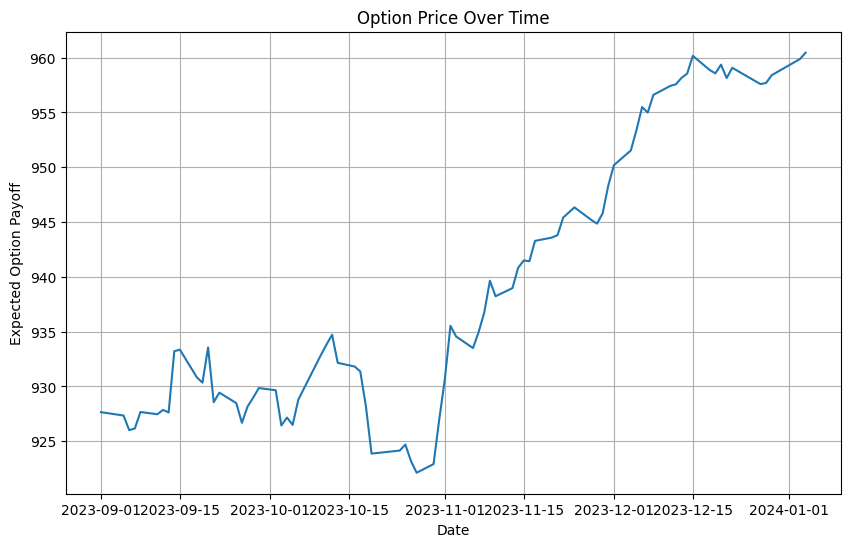

In [438]:
# Step 1: Define the Maturity Date and Pricing Dates
maturity_date = pd.to_datetime('2024-09-26')
pricing_start_date = pd.to_datetime('2023-09-01')
pricing_dates = pd.bdate_range(start=pricing_start_date, periods=90)

# Step 2: Initialize Data Structures
option_prices = []

mu = {}
sigma = {}
for index in ['SMI', 'STOXX50', 'SP500']:
    mean_return = returns[index].mean()
    variance = returns[index].var(ddof=1)
    mu[index] = mean_return
    sigma[index] = np.sqrt(variance) * np.sqrt(252)

corr_matrix = returns.corr()
chol_matrix = np.linalg.cholesky(corr_matrix)

n_simulations = 100000
dt = 1 / 252

# Step 3: Loop Over Each Pricing Date and Simulate Paths
for current_date in pricing_dates:

    simulation_dates = pd.bdate_range(start=current_date, end=maturity_date)
    n_timesteps = len(simulation_dates) - 1
    T = n_timesteps * dt

    if n_timesteps <= 0:
        break

    Z = np.random.normal(size=(n_timesteps, n_simulations, 3))
    Z_flat = Z.reshape(-1, 3)
    Z_correlated_flat = Z_flat @ chol_matrix.T
    Z_correlated = Z_correlated_flat.reshape(n_timesteps, n_simulations, 3)

    if current_date in r.index:
        initial_rate = r.loc[current_date, "United States Treasury 10-YR Rates"]
    else:
        initial_rate = r[r.index <= current_date]["United States Treasury 10-YR Rates"].iloc[-1]

    r_paths = np.zeros((n_timesteps + 1, n_simulations))
    r_paths[0, :] = initial_rate

    for i in range(1, n_timesteps + 1):
        Z_r = np.random.normal(size=n_simulations)
        r_t_prev = r_paths[i - 1]
        sqrt_term = np.sqrt(np.maximum(r_t_prev, 0) * dt)
        dr = kappa * (theta - r_t_prev) * dt + sigma_r * sqrt_term * Z_r
        r_paths[i] = np.maximum(r_t_prev + dr, 0)

    def get_initial_price(df, date):
        if date in df.index:
            return df.loc[date, 'Price']
        else:
            return df[df.index <= date]['Price'].iloc[-1]

    initial_prices = {
        'SMI': get_initial_price(smi, current_date),
        'STOXX50': get_initial_price(stoxx50, current_date),
        'SP500': get_initial_price(sp500, current_date)
    }

    def get_exchange_rate(df, date):
        if date in df.index:
            return df.loc[date, 'Price']
        else:
            return df[df.index <= date]['Price'].iloc[-1]

    eur_rate = get_exchange_rate(eur, current_date)
    chf_rate = get_exchange_rate(chf, current_date)

    sp500_init_level = 3977
    sp500_barrier = 2585

    stoxx_init_level = 4164 / eur_rate
    stoxx_barrier = 2707 / eur_rate

    smi_init_level = 10786 / chf_rate
    smi_barrier = 7011 / chf_rate

    price_paths = {index: np.zeros((n_timesteps + 1, n_simulations)) for index in ['SMI', 'STOXX50', 'SP500']}
    for index in ['SMI', 'STOXX50', 'SP500']:
        price_paths[index][0, :] = initial_prices[index]

    for i in range(1, n_timesteps + 1):
        r_t = r_paths[i-1]
        for idx, index in enumerate(['SMI', 'STOXX50', 'SP500']):
            drift_term = (r_t - 0.5 * sigma[index] ** 2) * dt
            diffusion_term = sigma[index] * np.sqrt(dt) * Z_correlated[i - 1, :, idx]
            price_paths[index][i, :] = price_paths[index][i - 1, :] * np.exp(drift_term + diffusion_term)

    for index in ['SMI', 'STOXX50', 'SP500']:
        price_paths[index] = price_paths[index].transpose()

    r_paths_T = r_paths.T

    barrier_breaches = np.zeros(n_simulations, dtype=bool)
    payoffs = np.zeros(n_simulations)

    cumulative_r = np.sum(r_paths_T[:, 1:] * dt, axis=1)
    discount_factors = np.exp(-cumulative_r)

    barrier_breaches |= (price_paths['SMI'][:, 1:] < smi_barrier).any(axis=1)
    barrier_breaches |= (price_paths['SP500'][:, 1:] < sp500_barrier).any(axis=1)
    barrier_breaches |= (price_paths['STOXX50'][:, 1:] < stoxx_barrier).any(axis=1)

    no_barrier_idx = np.where(~barrier_breaches)[0]
    payoffs[no_barrier_idx] = 1000 * discount_factors[no_barrier_idx]

    barrier_idx = np.where(barrier_breaches)[0]
    smi_final = price_paths['SMI'][barrier_idx, -1]
    sp500_final = price_paths['SP500'][barrier_idx, -1]
    stoxx50_final = price_paths['STOXX50'][barrier_idx, -1]

    min_ratio = np.minimum.reduce([
        smi_final / smi_init_level,
        sp500_final / sp500_init_level,
        stoxx50_final / stoxx_init_level,
        np.ones(len(barrier_idx))
    ])

    payoffs[barrier_idx] = 1000 * discount_factors[barrier_idx] * min_ratio

    expected_payoff = np.mean(payoffs)
    # Only add to option_prices if expected payoff is 920 or higher
    if expected_payoff >= 920:
        option_prices.append({
            'Date': current_date,
            'Expected Payoff': expected_payoff
        })
        print(f"Pricing date: {current_date.date()}")
        print(f"Expected Payoff at {current_date.date()}: {expected_payoff:.2f}")

# Step 4: Collect and Analyze the Results
option_prices_df = pd.DataFrame(option_prices)

plt.figure(figsize=(10, 6))
plt.plot(option_prices_df['Date'], option_prices_df['Expected Payoff'])
plt.xlabel('Date')
plt.ylabel('Expected Option Payoff')
plt.title('Option Price Over Time')
plt.grid(True)
plt.show()

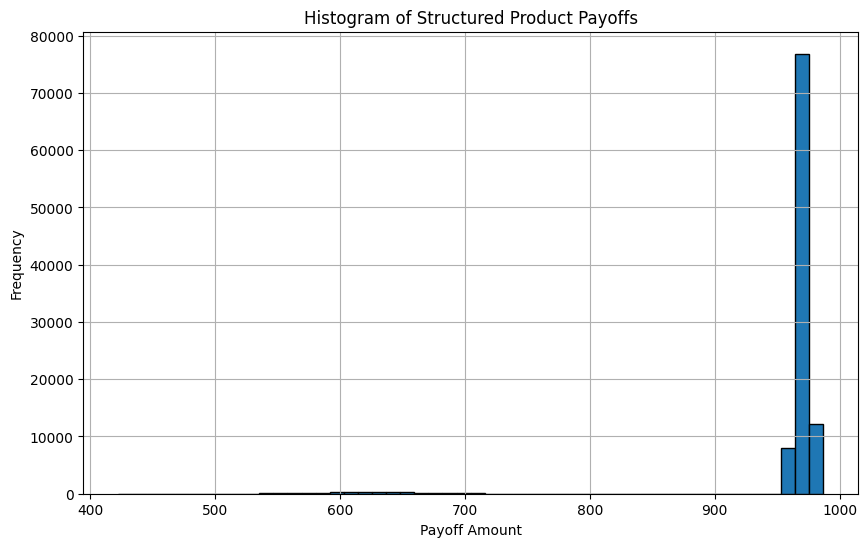

In [439]:
import matplotlib.pyplot as plt

# Convert payoffs to a NumPy array for easier manipulation
payoffs_array = np.array(payoffs)

# Plot histogram
plt.figure(figsize=(10, 6))
plt.hist(payoffs_array, bins=50, edgecolor='black')
plt.xlabel('Payoff Amount')
plt.ylabel('Frequency')
plt.title('Histogram of Structured Product Payoffs')
plt.grid(True)
plt.show()

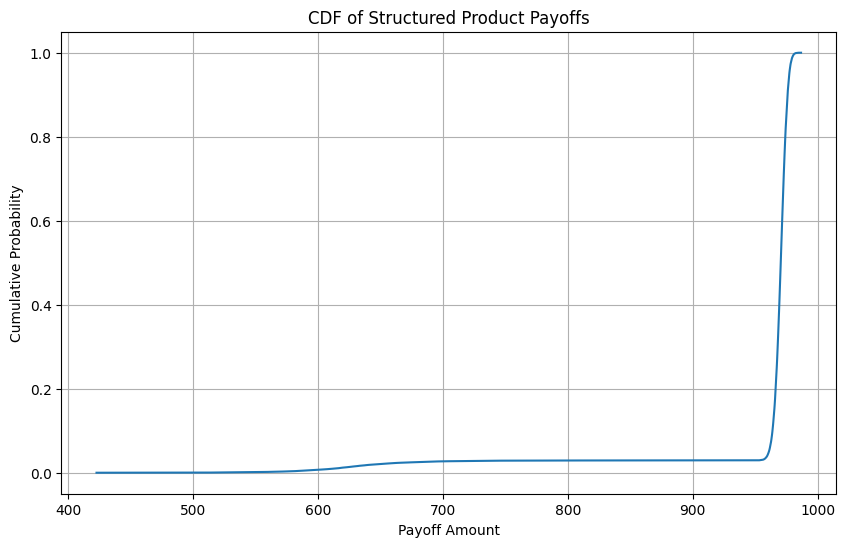

In [440]:
# Sort the payoffs
sorted_payoffs = np.sort(payoffs_array)

# Calculate the cumulative probabilities
cum_probs = np.linspace(0, 1, len(sorted_payoffs))

# Plot CDF
plt.figure(figsize=(10, 6))
plt.plot(sorted_payoffs, cum_probs)
plt.xlabel('Payoff Amount')
plt.ylabel('Cumulative Probability')
plt.title('CDF of Structured Product Payoffs')
plt.grid(True)
plt.show()

In [441]:
import pandas as pd

def load_data(file_path, date_column='Period'):
    """
    Load CSV data, parse the date column, and return a DataFrame.

    Parameters:
    - file_path (str): Path to the CSV file.
    - date_column (str): Column name containing date information.

    Returns:
    - pd.DataFrame: Loaded and processed DataFrame.
    """
    try:
        data = pd.read_csv(file_path)
        if date_column in data.columns:
            data[date_column] = pd.to_datetime(data[date_column])
            data.set_index(date_column, inplace=True)
        else:
            print(f"Warning: '{date_column}' column not found in {file_path}")
        return data
    except FileNotFoundError:
        print(f"Error: File not found - {file_path}")
        return pd.DataFrame()
    except Exception as e:
        print(f"Error: An error occurred while loading {file_path} - {e}")
        return pd.DataFrame()

## Load datasets with correct assignments
smi_file_path = "../Data CSV/SwitzerlandMarkov.csv"
smi_markov = load_data(smi_file_path)

sp500_file_path = "../Data CSV/USAMarkov.csv"
sp500_markov = load_data(sp500_file_path)

stoxx50_file_path = "../Data CSV/EurozoneMarkov.csv"
stoxx50_markov = load_data(stoxx50_file_path)

# Display one of the datasets
print("smi markov:")
print(smi_markov)
print("sp500:")
print(sp500_markov)
print("stoxx50:")
print(stoxx50_markov)



smi markov:
            GDP_YoY%  CPI_YoY%  Combined_Regime
Period                                         
2000-03-31    0.0432      1.48                2
2000-04-30    0.0432      1.40                2
2000-05-31    0.0432      1.58                2
2000-06-30    0.0410      1.84                2
2000-07-31    0.0410      1.89                2
...              ...       ...              ...
2024-04-30    0.0074      1.37                1
2024-05-31    0.0074      1.39                1
2024-06-30    0.0169      1.33                1
2024-07-31    0.0169      1.29                1
2024-08-31    0.0169      1.06                1

[294 rows x 3 columns]
sp500:
            GDP_YoY%  CPI_YoY%  Combined_Regime
Period                                         
2000-03-31    0.0422      3.76                4
2000-04-30    0.0422      3.07                4
2000-05-31    0.0422      3.19                4
2000-06-30    0.0524      3.73                4
2000-07-31    0.0524      3.66               

In [442]:
# Reindex the 'Combined_Regime' to daily frequency, forward-filling
smi_regime_daily = smi_markov['Combined_Regime'].reindex(returns.index, method='ffill')
sp500_regime_daily = sp500_markov['Combined_Regime'].reindex(returns.index, method='ffill')
stoxx50_regime_daily = stoxx50_markov['Combined_Regime'].reindex(returns.index, method='ffill')

# Add the regimes to the returns DataFrame
returns['SMI_Regime'] = smi_regime_daily
returns['SP500_Regime'] = sp500_regime_daily
returns['STOXX50_Regime'] = stoxx50_regime_daily

# Drop rows with missing regime data
returns.dropna(subset=['SMI_Regime', 'SP500_Regime', 'STOXX50_Regime'], inplace=True)

In [443]:
assets = ['SMI', 'SP500', 'STOXX50']
regime_params = {}

for asset in assets:
    regime_params[asset] = {}
    for regime in returns[asset + '_Regime'].unique():
        mask = returns[asset + '_Regime'] == regime
        returns_in_regime = returns.loc[mask, asset]
        mean_return = returns_in_regime.mean() * 252  # Annualized mean return
        volatility = returns_in_regime.std() * np.sqrt(252)  # Annualized volatility
        regime_params[asset][regime] = {
            'mean_return': mean_return,
            'volatility': volatility
        }

transition_matrices = {}

for asset in assets:
    regimes = sorted(returns[asset + '_Regime'].unique())
    n_regimes = len(regimes)
    counts = np.zeros((n_regimes, n_regimes))
    total_counts = np.zeros(n_regimes)

    asset_regimes = returns[asset + '_Regime'].values.astype(int)
    for t in range(len(asset_regimes) - 1):
        current_regime = asset_regimes[t] - 1  # Adjusting for zero-based indexing
        next_regime = asset_regimes[t + 1] - 1
        counts[current_regime, next_regime] += 1
        total_counts[current_regime] += 1

    transition_matrix = counts / total_counts[:, None]
    transition_matrices[asset] = np.nan_to_num(transition_matrix)
    
def simulate_price_paths_with_regime_switching(start_date, end_date, n_simulations):
    """
    Simulate price paths with regime switching from start_date to end_date.

    Parameters:
    - start_date (str or pd.Timestamp): The date from which the simulation starts.
    - end_date (str or pd.Timestamp): The date at which the simulation ends.
    - n_simulations (int): Number of simulation paths.

    Returns:
    - price_paths (dict): Dictionary with asset names as keys and arrays of shape
      (n_simulations, n_days) as values containing simulated price paths.
    """

    # Define assets
    assets = ['SMI', 'SP500', 'STOXX50']

    # Calculate the number of time steps based on business days
    n_timesteps = len(pd.bdate_range(start=start_date, end=end_date))

    # Initialize regime paths
    regime_paths = {}

    # Ensure returns DataFrame is sorted by index
    if not returns.index.is_monotonic_increasing:
        returns_sorted = returns.sort_index()
    else:
        returns_sorted = returns.copy()

    for asset in assets:
        # Get the transition matrix for the asset
        transition_matrix = transition_matrices[asset]

        # Initialize regime paths for each asset
        regime_paths[asset] = np.zeros((n_simulations, n_timesteps), dtype=int)

        # Set the initial regime based on the last known regime before the start date
        start_date_ts = pd.to_datetime(start_date)

        # Ensure start_date is within the index range
        if start_date_ts < returns_sorted.index.min():
            raise ValueError(f"start_date {start_date} is before the earliest date in returns data.")

        # Get all dates up to and including start_date
        dates_up_to_start = returns_sorted.index[returns_sorted.index <= start_date_ts]

        if len(dates_up_to_start) == 0:
            raise ValueError(f"No data available up to start_date {start_date}")

        # Get the last available date up to start_date
        last_available_date = dates_up_to_start[-1]

        # Retrieve the initial regime
        initial_regime_value = returns_sorted.loc[last_available_date, asset + '_Regime']

        # Handle the case where initial_regime_value might be a Series
        if isinstance(initial_regime_value, pd.Series):
            initial_regime_value = initial_regime_value.iloc[-1]

        initial_regime = int(initial_regime_value) - 1  # Zero-based indexing
        regime_paths[asset][:, 0] = initial_regime

        # Simulate regime paths
        for t in range(1, n_timesteps):
            current_regimes = regime_paths[asset][:, t - 1]
            probs = transition_matrix[current_regimes]
            random_values = np.random.rand(n_simulations)
            cumulative_probs = probs.cumsum(axis=1)
            next_regimes = (random_values[:, None] < cumulative_probs).argmax(axis=1)
            regime_paths[asset][:, t] = next_regimes

    # Assign volatility based on the regimes (no longer assigning drift)
    volatility = {}

    for asset in assets:
        volatility[asset] = np.zeros((n_simulations, n_timesteps))
        for regime in regime_params[asset]:
            mask = regime_paths[asset] == (regime - 1)
            volatility_value = regime_params[asset][regime]['volatility']
            volatility[asset][mask] = volatility_value

    # Retrieve the initial interest rate before the start date
    # Ensure r is sorted by index
    if not r.index.is_monotonic_increasing:
        r_sorted = r.sort_index()
    else:
        r_sorted = r.copy()

    # Ensure start_date is within the index range
    if start_date_ts < r_sorted.index.min():
        raise ValueError(f"start_date {start_date} is before the earliest date in interest rate data.")

    # Get all dates up to and including start_date
    dates_up_to_start_r = r_sorted.index[r_sorted.index <= start_date_ts]

    if len(dates_up_to_start_r) == 0:
        raise ValueError(f"No interest rate data available up to start_date {start_date}")

    # Get the last available date up to start_date
    last_available_date_r = dates_up_to_start_r[-1]

    # Retrieve the initial interest rate
    initial_rate_value = r_sorted.loc[last_available_date_r]

    # Handle the case where initial_rate_value might be a Series
    if isinstance(initial_rate_value, pd.Series):
        initial_rate_value = initial_rate_value.iloc[0]

    initial_rate = initial_rate_value

    # Initialize interest rate paths
    r_paths = np.zeros((n_simulations, n_timesteps))
    r_paths[:, 0] = initial_rate

    # Initialize price paths
    initial_prices = {'SMI': 1000, 'STOXX50': 3500, 'SP500': 4500}
    price_paths = {index: np.zeros((n_simulations, n_timesteps)) for index in assets}
    for index in assets:
        price_paths[index][:, 0] = initial_prices[index]

    # Generate the Cholesky decomposition of the correlation matrix
    corr_matrix = returns[assets].corr()
    chol_matrix = np.linalg.cholesky(corr_matrix)

    epsilon = 1e-6  # Small number to prevent division by zero

    # Simulation loop
    for t in range(1, n_timesteps):
        # Simulate interest rates
        Z_r = np.random.normal(size=n_simulations)
        r_t_prev = r_paths[:, t - 1]
        dr = (kappa * (theta - r_t_prev) * dt +
              sigma_r * np.sqrt(np.maximum(r_t_prev, 0)) * np.sqrt(dt) * Z_r)
        r_t = np.maximum(r_t_prev + dr, 0)
        r_paths[:, t] = r_t

        # Generate correlated random variables
        Z = np.random.normal(size=(n_simulations, len(assets)))
        Z_correlated = Z @ chol_matrix.T

        for idx, asset in enumerate(assets):
            # Retrieve volatility
            volatility_t = volatility[asset][:, t - 1]
            # Use the risk-free rate as the drift
            drift_t = r_t  # r_t is of shape (n_simulations,)

            # Calculate drift term using the risk-free interest rate
            drift_term = (drift_t - 0.5 * volatility_t ** 2) * dt

            # Calculate diffusion term
            diffusion_term = volatility_t * np.sqrt(dt) * Z_correlated[:, idx]

            # Update asset prices
            price_paths[asset][:, t] = price_paths[asset][:, t - 1] * np.exp(drift_term + diffusion_term)

    return price_paths

In [444]:
# Prepare the data and parameters
start_date = '2024-08-01'
end_date = '2024-12-16'
n_simulations = 1000

# Call the function
price_paths = simulate_price_paths_with_regime_switching(start_date, end_date, n_simulations)

# Access the simulated price paths
smi_price_paths = price_paths['SMI']
sp500_price_paths = price_paths['SP500']
stoxx50_price_paths = price_paths['STOXX50']

In [445]:
sp500_price_paths

array([[4500.        , 4478.35354191, 4384.90083237, ..., 3936.19334963,
        3888.28753762, 3931.14126337],
       [4500.        , 4543.38464039, 4520.39661801, ..., 4745.98553446,
        4790.53651115, 4810.52702997],
       [4500.        , 4596.46468472, 4634.3662807 , ..., 4627.17957454,
        4603.62797869, 4609.66965638],
       ...,
       [4500.        , 4514.01391931, 4496.9722388 , ..., 5048.53039949,
        5074.93603825, 5115.41440196],
       [4500.        , 4454.09774646, 4470.29099578, ..., 4445.64063339,
        4423.87751272, 4432.88843338],
       [4500.        , 4510.69848617, 4574.95079653, ..., 5133.61645469,
        5185.18142262, 5159.38483189]])

In [446]:
def plot_price_paths(price_paths, asset_name, n_paths=100):
    """
    Plots the simulated price paths for a given asset.

    Parameters:
    - price_paths (dict): Dictionary containing price paths for each asset.
    - asset_name (str): Name of the asset to plot.
    - n_paths (int): Number of individual paths to plot.

    Returns:
    - None
    """
    import matplotlib.pyplot as plt
    import numpy as np

    # Extract the price paths for the asset
    paths = price_paths[asset_name]  # Shape: (n_simulations, n_timesteps)

    # Determine the number of time steps
    n_simulations, n_timesteps = paths.shape
    time = np.arange(n_timesteps)

    # Plot a subset of individual price paths
    plt.figure(figsize=(12, 6))
    for i in range(min(n_paths, n_simulations)):
        plt.plot(time, paths[i], color='lightgray', linewidth=0.5)

    # Calculate and plot the mean price path
    mean_path = np.mean(paths, axis=0)
    plt.plot(time, mean_path, color='blue', linewidth=2, label='Mean Path')

    # Calculate and plot the 5th and 95th percentiles
    percentile_5 = np.percentile(paths, 5, axis=0)
    percentile_95 = np.percentile(paths, 95, axis=0)
    plt.fill_between(time, percentile_5, percentile_95, color='blue', alpha=0.2, label='5th-95th Percentile')

    # Customize the plot
    plt.title(f'Simulated Price Paths for {asset_name}')
    plt.xlabel('Time Steps (Days)')
    plt.ylabel('Price')
    plt.legend()
    plt.grid(True)
    plt.show()

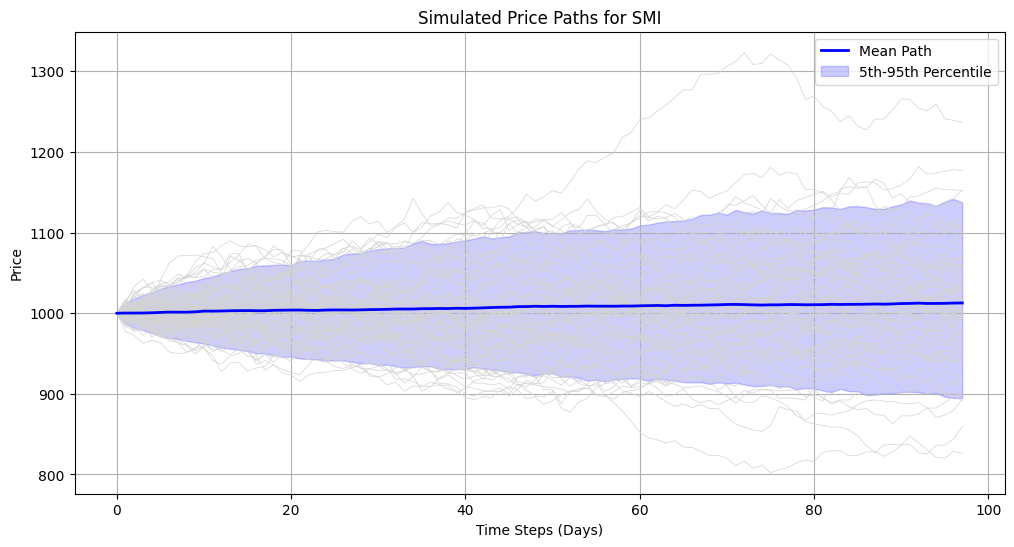

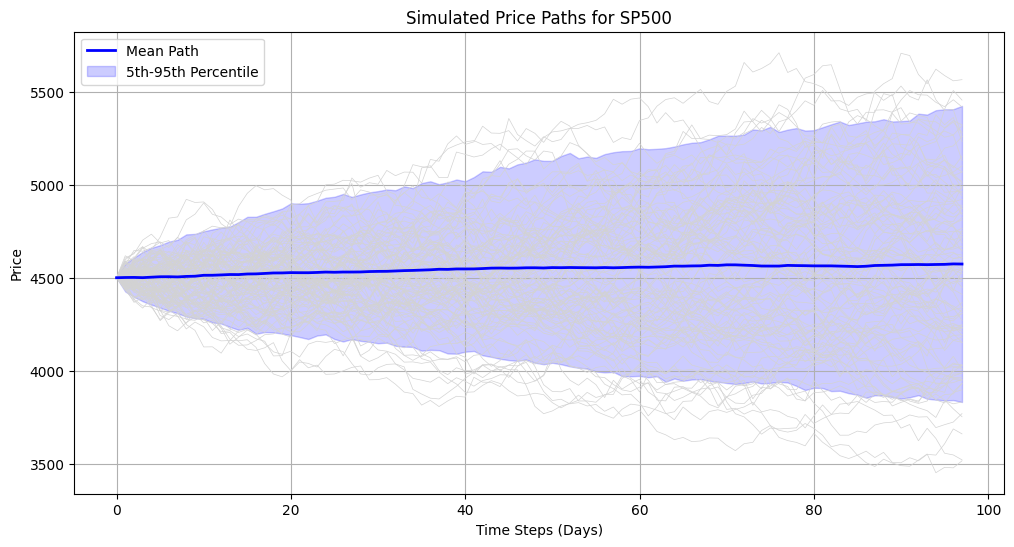

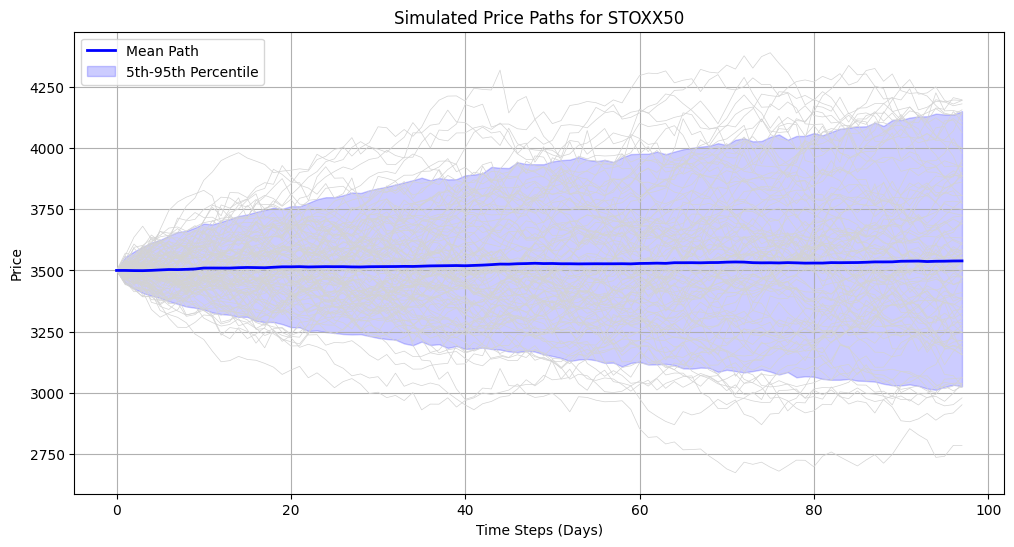

In [447]:
# Plotting price paths for SMI
plot_price_paths(price_paths, 'SMI', n_paths=100)

# Plotting price paths for SP500
plot_price_paths(price_paths, 'SP500', n_paths=100)

# Plotting price paths for STOXX50
plot_price_paths(price_paths, 'STOXX50', n_paths=100)

In [448]:
date = '2024-01-01'
n_simulations = 100000
n_timesteps = len(pd.bdate_range(start='2024-08-01',end='2024-12-16')) # Number of trading days in a year

regime_paths = {}

for asset in assets:
    regimes = sorted(returns[asset + '_Regime'].unique())
    n_regimes = len(regimes)
    transition_matrix = transition_matrices[asset]

    # Initialize regime paths
    regime_paths[asset] = np.zeros((n_simulations, n_timesteps+1), dtype=int)
    initial_regime = int(returns[asset + '_Regime'].iloc[-1]) - 1  # Zero-based index
    regime_paths[asset][:, 0] = initial_regime

    for t in range(1, n_timesteps+1):
        current_regimes = regime_paths[asset][:, t - 1]
        probs = transition_matrix[current_regimes]
        random_values = np.random.rand(n_simulations)
        cumulative_probs = probs.cumsum(axis=1)
        next_regimes = (random_values[:, None] < cumulative_probs).argmax(axis=1)
        regime_paths[asset][:, t] = next_regimes

drift = {}
volatility = {}

for asset in assets:
    drift[asset] = np.zeros((n_simulations, n_timesteps+1))
    volatility[asset] = np.zeros((n_simulations, n_timesteps+1))
    for regime in regime_params[asset]:
        mask = regime_paths[asset] == (regime - 1)
        drift[asset][mask] = regime_params[asset][regime]['mean_return']
        volatility[asset][mask] = regime_params[asset][regime]['volatility']


In [449]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Assume r is defined as per your DataFrame
# Define other required variables
n_timesteps = 252  # For one year of daily data
kappa = 0.1        # Speed of mean reversion
theta = 0.05       # Long-term mean rate
sigma_r = 0.02     # Volatility of interest rate

# Correctly retrieve the initial rate
initial_rate = r.iloc[-1, 0]

# Historical correlation matrix
corr_matrix = returns[['SMI', 'SP500', 'STOXX50']].corr()
chol_matrix = np.linalg.cholesky(corr_matrix)

# Initialize interest rate paths
r_paths = np.zeros((n_simulations, n_timesteps + 1))
r_paths[:, 0] = initial_rate

dt = 1 / 252  # Daily time step

# Initialize price paths
initial_prices = {'SMI': 1000, 'STOXX50': 3500, 'SP500': 4500}
price_paths = {index: np.zeros((n_simulations, n_timesteps + 1)) for index in ['SMI', 'STOXX50', 'SP500']}
for index in ['SMI', 'STOXX50', 'SP500']:
    price_paths[index][:, 0] = initial_prices[index]

# Simulation loop
epsilon = 1e-6  # Small number to prevent log(0)
for t in range(1, n_timesteps+1):
    # Simulate interest rates
    Z_r = np.random.normal(size=n_simulations)
    r_t_prev = r_paths[:, t - 1]
    dr = kappa * (theta - r_t_prev) * dt + sigma_r * np.sqrt(np.maximum(r_t_prev, 0) * dt) * Z_r
    r_paths[:, t] = np.maximum(r_t_prev + dr, 0)
    r_t = r_paths[:, t]
    r_t_positive = np.maximum(r_t, epsilon)  # Prevent log(0)

    # Generate correlated random variables
    Z = np.random.normal(size=(n_simulations, 3))
    Z_correlated = Z @ chol_matrix.T

    for idx, asset in enumerate(['SMI', 'STOXX50', 'SP500']):
        # Retrieve drift and volatility
        volatility_t = volatility[asset][:, t - 1]

        # Calculate drift term using the stochastic interest rate
        drift_term = (r_t_positive - 0.5 * volatility_t ** 2) * dt

        # Calculate diffusion term
        diffusion_term = volatility_t * np.sqrt(dt) * Z_correlated[:, idx]

        # Update asset prices
        price_paths[asset][:, t] = price_paths[asset][:, t - 1] * np.exp(drift_term + diffusion_term)

# Plotting interest rate paths
plt.figure(figsize=(10, 6))
for i in range(min(n_simulations, 50)):  # Plotting fewer paths for clarity
    plt.plot(range(n_timesteps), r_paths[i, :], lw=0.8)
plt.xlabel("Time (Days)")
plt.ylabel("Interest Rate (r)")
plt.title("Simulated CIR Paths for Interest Rate")
plt.show()

# Plotting asset price paths
plt.figure(figsize=(10, 6))
for i in range(min(n_simulations, 1000)):
    plt.plot(range(n_timesteps), price_paths['SMI'][i, :], lw=0.8)
plt.xlabel("Time (Days)")
plt.ylabel("SMI Price")
plt.title("Simulated GBM Paths with Stochastic Interest Rate")
plt.show()

IndexError: index 99 is out of bounds for axis 1 with size 99

In [ ]:
date = '2024-08-01'
n_simulations = 10000
n_timesteps = len(pd.bdate_range(start='2024-08-01',end='2024-12-16'))

h = 1e-4

price_paths_up = {index: np.zeros((n_timesteps + 1, n_simulations)) for index in ['SMI', 'STOXX50', 'SP500']}
price_paths_down = {index: np.zeros((n_timesteps + 1, n_simulations)) for index in ['SMI', 'STOXX50', 'SP500']}

mu = {}
sigma = {}
for index in ['SMI', 'STOXX50', 'SP500']:
    mean_return = returns[index].mean()
    variance = returns[index].var()
    mu[index] = mean_return
    sigma[index] = np.sqrt(variance)*np.sqrt(252)
print(sigma)

corr_matrix = returns.corr()
chol_matrix = np.linalg.cholesky(corr_matrix)

Z = np.random.normal(size=(n_timesteps, n_simulations, 3))
Z_flat = Z.reshape(-1, 3)
Z_correlated_flat = Z_flat @ chol_matrix.T
Z_correlated = Z_correlated_flat.reshape(n_timesteps, n_simulations, 3)

initial_prices = {
    'SMI': smi['Price'].iloc[-1],
    'STOXX50': stoxx50['Price'].iloc[-1],
    'SP500': sp500['Price'].iloc[-1]
}

# print(smi['Price'])
# print(stoxx50['Price'])
# print(sp500['Price'])

price_paths = {index: np.zeros((n_timesteps + 1, n_simulations)) for index in ['SMI', 'STOXX50', 'SP500']}

for index in ['SMI', 'STOXX50', 'SP500']:
    price_paths[index][0] = initial_prices[index]
    price_paths_up[index][0] = initial_prices[index] + h
    price_paths_down[index][0] = initial_prices[index] - h
#print(price_paths)

initial_rate = r[-1]
r_paths = np.zeros((n_timesteps + 1, n_simulations))
r_paths[0, :] = initial_rate

#print(r_paths)

for i in range(1, n_timesteps + 1):
    Z_r = np.random.normal(size=n_simulations)
    r_t_prev = r_paths[i - 1]
    dr = kappa * (theta - r_t_prev) * dt + sigma_r * np.sqrt(r_t_prev * dt) * Z_r
    r_paths[i] = np.maximum(r_t_prev + dr, 0)

    for idx, index in enumerate(['SMI', 'STOXX50', 'SP500']):
        #drift_term = (r_paths[i] - 0.5 * sigma[index] ** 2) * dt
        drift_term = (r_paths[i] - 0.5 * sigma[index] ** 2) * dt
        diffusion_term = sigma[index] * np.sqrt(dt) * Z_correlated[i - 1, :, idx]
        price_paths[index][i] = price_paths[index][i - 1] * np.exp(drift_term + diffusion_term)

        price_paths_up[index][i] = price_paths_up[index][i - 1] * np.exp(drift_term + diffusion_term)

        price_paths_down[index][i] = price_paths_down[index][i - 1] * np.exp(drift_term + diffusion_term)

for index in ['SMI', 'STOXX50', 'SP500']:
    price_paths[index] = price_paths[index].transpose()

delta_paths = {index: np.zeros((n_timesteps + 1, n_simulations)) for index in ['SMI', 'STOXX50', 'SP500']}
for index in ['SMI', 'STOXX50', 'SP500']:
    delta_paths[index] = (price_paths_up[index] - price_paths_down[index]) / (2 * h)

# Average Delta at each time step
avg_delta_SMI = delta_paths['SMI'].mean(axis=1)
avg_delta_STOXX50 = delta_paths['STOXX50'].mean(axis=1)
avg_delta_SP500 = delta_paths['SP500'].mean(axis=1)
                                        

plt.figure(figsize=(10, 6))
plt.plot(range(n_timesteps + 1), avg_delta_SMI, lw=2, label="Average Delta")
plt.xlabel("Time (Days)")
plt.ylabel("Delta")
plt.title("Average Simulated Delta Path for SMI")
plt.legend()
plt.show()

plt.figure(figsize=(10, 6))
plt.plot(range(n_timesteps + 1), avg_delta_STOXX50, lw=2, label="Average Delta")
plt.xlabel("Time (Days)")
plt.ylabel("Delta")
plt.title("Average Simulated Delta Path for STOXX50")
plt.legend()
plt.show()

plt.figure(figsize=(10, 6))
plt.plot(range(n_timesteps + 1), avg_delta_SP500, lw=2, label="Average Delta")
plt.xlabel("Time (Days)")
plt.ylabel("Delta")
plt.title("Average Simulated Delta Path for SP500")
plt.legend()
plt.show()

plt.figure(figsize=(10, 6))
for i in range(n_simulations):
    plt.plot(range(n_timesteps + 1), r_paths[:, i], lw=0.8)
plt.xlabel("Time (Days)")
plt.ylabel("Interest Rate (r)")
plt.title("Simulated CIR Paths for Interest Rate")
plt.show()

plt.figure(figsize=(10, 6))
for i in range(n_simulations):
    plt.plot(range(n_timesteps + 1), price_paths['SMI'][i, :], lw=0.8)
plt.xlabel("Time (Days)")
plt.ylabel("SMI Price")
plt.title("Simulated GBM Paths with Stochastic Interest Rate")

{'SMI': np.float64(0.15822651756329695), 'STOXX50': np.float64(0.21432133223506833), 'SP500': np.float64(0.21731958745722776)}


ValueError: matmul: Input operand 1 has a mismatch in its core dimension 0, with gufunc signature (n?,k),(k,m?)->(n?,m?) (size 6 is different from 3)

In [ ]:
def simulate_price_paths_with_regime_switching(start_date, n_simulations): 
    pass
    return price_paths

price_paths = dict {"SMI": array of shape(n_simulations, ndays), ...}
